In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_fashion_mnist import Net, Net2c, FashionCNN
from visualize import *
import dset_fashion_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# set args
args = dset.get_args()
args.cuda = "Trie"
args.test_batch_size = 50

# load fashion-mnist dataset
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# model
model = FashionCNN().to(device)
model.load_state_dict(torch.load('./fashion-mnist.model.pth', map_location=device))
model = model.eval().to(device)
dset.test(model, test_loader, args)


Test set: Average loss: -47.7807, Accuracy: 9032/10000 (90.32%)



In [26]:
# foolbox model
preprocessing = dict(mean=[0,], std=[1,], axis=-3)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=preprocessing)

# get a batch of images and labels and print the accuracy
images, labels = iter(test_loader).next()
images = images.numpy()
labels = labels.numpy()
print(np.mean(fmodel.forward(images).argmax(axis=-1) == labels))

# apply the attack
attack = foolbox.attacks.FGSM(fmodel)
im_adversarials = attack(images, labels)
# if the i'th image is misclassfied without a perturbation, then adversarials[i] will be the same as images[i]
# if the attack fails to find an adversarial for the i'th image, then adversarials[i] will all be np.nan
# Foolbox guarantees that all returned adversarials are in fact in adversarials
print(np.mean(fmodel.forward(im_adversarials).argmax(axis=-1) == labels))

# # You can always get the actual adversarial class that was observed for that sample by Foolbox by
# # passing `unpack=False` to get the actual `Adversarial` objects:
attack = foolbox.attacks.FGSM(fmodel, distance=foolbox.distances.Linf)
adversarials = attack(images, labels, unpack=False)

adversarial_classes = np.asarray([a.adversarial_class for a in adversarials])
# print(labels)
# print(adversarial_classes)
# print(np.mean(adversarial_classes == labels))  # will always be 0.0

# The `Adversarial` objects also provide a `distance` attribute. Note that the distances
# can be 0 (misclassified without perturbation) and inf (attack failed).
distances = np.asarray([a.distance.value for a in adversarials])
print("{:.1e}, {:.1e}, {:.1e}".format(distances.min(), np.median(distances), distances.max()))
print("{} of {} attacks failed".format(sum(adv.distance.value == np.inf for adv in adversarials), len(adversarials)))
print("{} of {} inputs misclassified without perturbation".format(sum(adv.distance.value == 0 for adv in adversarials), len(adversarials)))

0.92
0.0
0.0e+00, 2.5e-02, inf
2 of 50 attacks failed
4 of 50 inputs misclassified without perturbation


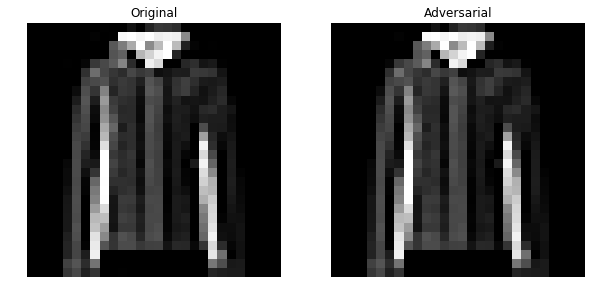

True and perturbed labels:  Coat Pullover


In [27]:
# index with minimum dist to orig. image while perturbation suceed
min_idx = np.where(distances == np.min(distances[np.nonzero(distances)]))[0][0]
im = images[min_idx]
im_a = im_adversarials[min_idx]
viz_im_a(im.squeeze(), im_a.squeeze())
print('True and perturbed labels: ', dset.output_label(labels[min_idx]), dset.output_label(adversarial_classes[min_idx]))

## Interpret adversarial images

In [28]:
# FFT
t = lambda x: torch.fft(torch.stack((x, torch.zeros_like(x)),dim=4), 2)
transform_i = modularize(lambda x: torch.ifft(x, 2)[...,0])

# prepend transformation
model_t = TrimModel(model, transform_i)

# interp methods
attr_methods = ['IG', 'DeepLift', 'SHAP', 'CD', 'InputXGradient']

# band center and width
band_centers = list(np.arange(1, 40) * 0.025)
band_width_lower = 0.025
band_width_upper = 0.025

# indexes
idx_adv = np.logical_and(distances > 0, distances < np.inf)
idx_fail = distances == np.inf


#### images that succeed adversarial attach

In [ ]:
im_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
#     'CD': [], no support on batch with different class labels
    'InputXGradient': []
}
im = torch.from_numpy(images[idx_adv]).to(device)
im_t = t(im)
target = torch.from_numpy(labels[idx_adv]).to(device)

# attr
results = get_attributions(im_t, model_t, class_num=target)

In [ ]:
results

In [ ]:
# attr
results = get_attributions(im_t, model_t, class_num=np.int(target))    
for band_center in band_centers:
    mask = freq_band(28, band_center, band_width_lower, band_width_upper)
    for name in attr_methods:
        im_attr = np.sum(fftshift(results[name]) * mask) 
        scores[name].append(np.array([im_attr])) 
im_scores['IG'].append(np.array(scores['IG']).flatten())
im_scores['DeepLift'].append(np.array(scores['DeepLift']).flatten())
im_scores['SHAP'].append(np.array(scores['SHAP']).flatten())
im_scores['CD'].append(np.array(scores['CD']).flatten())
im_scores['InputXGradient'].append(np.array(scores['InputXGradient']).flatten())
print('\riteration', i, end='')
im_scores['IG'] = np.array(im_scores['IG'])
im_scores['DeepLift'] = np.array(im_scores['DeepLift'])
im_scores['SHAP'] = np.array(im_scores['SHAP'])
im_scores['CD'] = np.array(im_scores['CD'])
im_scores['InputXGradient'] = np.array(im_scores['InputXGradient'])

In [ ]:
im_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'CD': [],
    'InputXGradient': []
}
for i in range(np.sum(idx_adv)):
    scores = {
        'IG': [],
        'DeepLift': [],
        'SHAP': [],
        'CD': [],
        'InputXGradient': []
    }    
    im = images[idx_adv][i:i+1]
    im = torch.Tensor(im).to(device)
    im_t = t(im)
    target = labels[idx_adv][i:i+1].item()
    
    # attr
    results = get_attributions(im_t, model_t, class_num=np.int(target))    
    for band_center in band_centers:
        mask = freq_band(28, band_center, band_width_lower, band_width_upper)
        for name in attr_methods:
            im_attr = np.sum(fftshift(results[name]) * mask) 
            scores[name].append(np.array([im_attr])) 
    im_scores['IG'].append(np.array(scores['IG']).flatten())
    im_scores['DeepLift'].append(np.array(scores['DeepLift']).flatten())
    im_scores['SHAP'].append(np.array(scores['SHAP']).flatten())
    im_scores['CD'].append(np.array(scores['CD']).flatten())
    im_scores['InputXGradient'].append(np.array(scores['InputXGradient']).flatten())
    print('\riteration', i, end='')
im_scores['IG'] = np.array(im_scores['IG'])
im_scores['DeepLift'] = np.array(im_scores['DeepLift'])
im_scores['SHAP'] = np.array(im_scores['SHAP'])
im_scores['CD'] = np.array(im_scores['CD'])
im_scores['InputXGradient'] = np.array(im_scores['InputXGradient'])

#### adversarial images 

In [ ]:
im_a_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'CD': [],
    'InputXGradient': []
}
for i in range(np.sum(idx_adv)):
    scores = {
        'IG': [],
        'DeepLift': [],
        'SHAP': [],
        'CD': [],
        'InputXGradient': []
    }    
    im = im_adversarials[idx_adv][i:i+1]
    im = torch.Tensor(im).to(device)
    im_t = t(im)
    target = adversarial_classes[idx_adv][i:i+1].item()
    
    # attr
    results = get_attributions(im_t, model_t, class_num=np.int(target))    
    for band_center in band_centers:
        mask = freq_band(28, band_center, band_width_lower, band_width_upper)
        for name in attr_methods:
            im_attr = np.sum(fftshift(results[name]) * mask) 
            scores[name].append(np.array([im_attr])) 
    im_a_scores['IG'].append(np.array(scores['IG']).flatten())
    im_a_scores['DeepLift'].append(np.array(scores['DeepLift']).flatten())
    im_a_scores['SHAP'].append(np.array(scores['SHAP']).flatten())
    im_a_scores['CD'].append(np.array(scores['CD']).flatten())
    im_a_scores['InputXGradient'].append(np.array(scores['InputXGradient']).flatten())
    print('\riteration', i, end='')
im_a_scores['IG'] = np.array(im_a_scores['IG'])
im_a_scores['DeepLift'] = np.array(im_a_scores['DeepLift'])
im_a_scores['SHAP'] = np.array(im_a_scores['SHAP'])
im_a_scores['CD'] = np.array(im_a_scores['CD'])
im_a_scores['InputXGradient'] = np.array(im_a_scores['InputXGradient'])

#### images that fail adversarial attack

In [ ]:
im_f_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'CD': [],
    'InputXGradient': []
}
for i in range(np.sum(idx_fail)):
    scores = {
        'IG': [],
        'DeepLift': [],
        'SHAP': [],
        'CD': [],
        'InputXGradient': []
    }    
    im = images[idx_fail][i:i+1]
    im = torch.Tensor(im).to(device)
    im_t = t(im)
    target = labels[idx_fail][i:i+1].item()
    
    # attr
    results = get_attributions(im_t, model_t, class_num=np.int(target))    
    for band_center in band_centers:
        mask = freq_band(28, band_center, band_width_lower, band_width_upper)
        for name in attr_methods:
            im_attr = np.sum(fftshift(results[name]) * mask) 
            scores[name].append(np.array([im_attr])) 
    im_f_scores['IG'].append(np.array(scores['IG']).flatten())
    im_f_scores['DeepLift'].append(np.array(scores['DeepLift']).flatten())
    im_f_scores['SHAP'].append(np.array(scores['SHAP']).flatten())
    im_f_scores['CD'].append(np.array(scores['CD']).flatten())
    im_f_scores['InputXGradient'].append(np.array(scores['InputXGradient']).flatten())
    print('\riteration', i, end='')
im_f_scores['IG'] = np.array(im_f_scores['IG'])
im_f_scores['DeepLift'] = np.array(im_f_scores['DeepLift'])
im_f_scores['SHAP'] = np.array(im_f_scores['SHAP'])
im_f_scores['CD'] = np.array(im_f_scores['CD'])
im_f_scores['InputXGradient'] = np.array(im_f_scores['InputXGradient'])